<a href="https://colab.research.google.com/github/Arkya187/Medical-Visual_Question_Answering/blob/main/VQA_using_CNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mitanshuchakrawarty/medical-visual-question-answering")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'medical-visual-question-answering' dataset.
Path to dataset files: /kaggle/input/medical-visual-question-answering


In [ ]:
metadata = pd.read_excel("/kaggle/input/medical-visual-question-answering/VQA_RAD Dataset Public.xlsx")
metadata

,QID_unique,QID_para,QID_linked,IMAGEID_case,IMAGEID,IMAGEORGAN,EVALUATION,QUESTION,Q_REPHASE,Q_RELATION,Q_FRAMED,Q_TYPE,ANSWER,A_TYPE
0,0,freeform,03f451ca-de62-4617-9679-e836026a7642,https://medpix.nlm.nih.gov/case?id=48e1dd0e-85...,https://medpix.nlm.nih.gov/images/full/synpic5...,HEAD,not evaluated,Are regions of the brain infarcted?,NaN,NaN,NaN,PRES,Yes,CLOSED
1,1,freeform,06e26b2c-04b9-42bc-8e98-1de30a0f7682,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,not evaluated,Are the lungs normal appearing?,NaN,NaN,NaN,ABN,No,CLOSED
2,2,freeform,0d0e8b6b-7753-4788-9b6d-dc7f25250c3f,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,not evaluated,Is there evidence of a pneumothorax,NaN,NaN,NaN,PRES,No,CLOSED
3,3,freeform,0e90b6bc-265f-490b-a039-509b9907a3cb,https://medpix.nlm.nih.gov/case?id=19aa8a2b-35...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,given,What type of imaging does this not represent?,NaN,NaN,NaN,MODALITY,ultrasound,OPEN
4,4,freeform,1179f612-12e0-4dda-aee0-f14a5200be7b,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,given,Is this a MRI of the chest?,NaN,NaN,NaN,MODALITY,no,CLOSED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,2243,para,6e01da36-ccda-4462-81c4-c7b5e495fb99,https://medpix.nlm.nih.gov/case?id=5dd90eed-4b...,https://medpix.nlm.nih.gov/images/full/synpic5...,HEAD,evaluated,"Is this image modality T1, T2, or FLAIR?","Is this a T1 weighted, T2 weighted, or FLAIR i...",strict agreement,What is/are the image weighting of the MRI?,MODALITY,FLAIR,CLOSED
2244,2244,freeform,9a4e1869-5c76-4af6-81e4-1864db18bbbe,https://medpix.nlm.nih.gov/case?id=5133d5d4-19...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,evaluated,Is this a PA film?,Is this film taken in a PA modality?,strict agreement,NaN,PLANE,Yes,CLOSED
2245,2245,para,9a4e1869-5c76-4af6-81e4-1864db18bbbe,https://medpix.nlm.nih.gov/case?id=5133d5d4-19...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,evaluated,Is this film taken in a PA modality?,Is this a PA film?,strict agreement,NaN,PLANE,Yes,CLOSED
2246,2246,freeform,e2c3565f-a137-406d-8ab0-de869c86cbee,https://medpix.nlm.nih.gov/case?id=187330b9-9d...,https://medpix.nlm.nih.gov/images/full/synpic3...,ABD,evaluated,What is the hypodensity located inside the ver...,What is the hypo-dense area seen in the verteb...,strict agreement,NaN,PRES,Nucleus Pulposus,OPEN


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2248 entries, 0 to 2247
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   QID_unique    2248 non-null   int64 
 1   QID_para      2248 non-null   object
 2   QID_linked    2248 non-null   object
 3   IMAGEID_case  2248 non-null   object
 4   IMAGEID       2248 non-null   object
 5   IMAGEORGAN    2248 non-null   object
 6   EVALUATION    2248 non-null   object
 7   QUESTION      2248 non-null   object
 8   Q_REPHASE     1776 non-null   object
 9   Q_RELATION    1487 non-null   object
 10  Q_FRAMED      1267 non-null   object
 11  Q_TYPE        2248 non-null   object
 12  ANSWER        2247 non-null   object
 13  A_TYPE        2248 non-null   object
dtypes: int64(1), object(13)
memory usage: 246.0+ KB


In [ ]:
metadata["Q_TYPE"].value_counts()

,count
Q_TYPE,
PRES,800
POS,316
ABN,202
OTHER,194
MODALITY,185
SIZE,171
PLANE,120
ATTRIB,87
ORGAN,59


In [ ]:
metadata.isna().sum()

,0
QID_unique,0
QID_para,0
QID_linked,0
IMAGEID_case,0
IMAGEID,0
IMAGEORGAN,0
EVALUATION,0
QUESTION,0
Q_REPHASE,472
Q_RELATION,761


In [ ]:
metadata["A_TYPE"].value_counts()

,count
A_TYPE,
CLOSED,1297
OPEN,949
CLOSED,2


In [ ]:
metadata["ANSWER"].value_counts()[:20]

,count
ANSWER,
No,486
Yes,347
yes,239
no,120
Axial,28
Right,22
Left,18
axial,15
PA,15


<Axes: xlabel='IMAGEORGAN'>

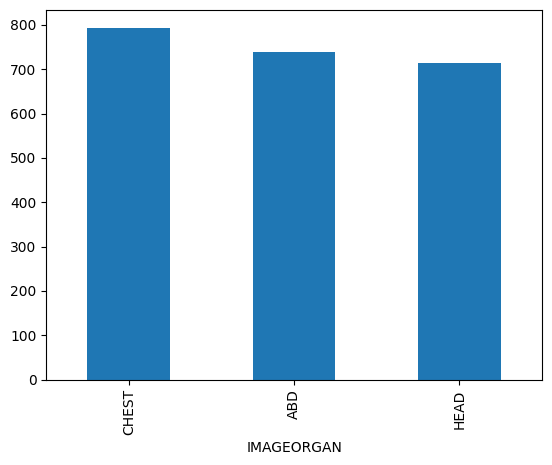

In [ ]:
metadata["IMAGEORGAN"].value_counts().plot.bar()

In [ ]:
sampledata = metadata[(metadata["ANSWER"] == "Yes") | (metadata["ANSWER"] == "No") | (metadata["ANSWER"] == "yes") | (metadata["ANSWER"] == "no") ]
sampledata.reset_index(inplace = True, drop = True)
sampledata

,QID_unique,QID_para,QID_linked,IMAGEID_case,IMAGEID,IMAGEORGAN,EVALUATION,QUESTION,Q_REPHASE,Q_RELATION,Q_FRAMED,Q_TYPE,ANSWER,A_TYPE
0,0,freeform,03f451ca-de62-4617-9679-e836026a7642,https://medpix.nlm.nih.gov/case?id=48e1dd0e-85...,https://medpix.nlm.nih.gov/images/full/synpic5...,HEAD,not evaluated,Are regions of the brain infarcted?,NaN,NaN,NaN,PRES,Yes,CLOSED
1,1,freeform,06e26b2c-04b9-42bc-8e98-1de30a0f7682,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,not evaluated,Are the lungs normal appearing?,NaN,NaN,NaN,ABN,No,CLOSED
2,2,freeform,0d0e8b6b-7753-4788-9b6d-dc7f25250c3f,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,not evaluated,Is there evidence of a pneumothorax,NaN,NaN,NaN,PRES,No,CLOSED
3,4,freeform,1179f612-12e0-4dda-aee0-f14a5200be7b,https://medpix.nlm.nih.gov/case?id=b197277b-69...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,given,Is this a MRI of the chest?,NaN,NaN,NaN,MODALITY,no,CLOSED
4,6,freeform,27169439-b749-4b2f-8abe-bfb57a46ce53,https://medpix.nlm.nih.gov/case?id=19aa8a2b-35...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,not evaluated,Is the trachea midline?,NaN,NaN,NaN,PRES,yes,CLOSED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,2236,freeform,2f181109-0890-4447-b2fd-645176ba9aa8,https://medpix.nlm.nih.gov/case?id=693c5942-66...,https://medpix.nlm.nih.gov/images/full/synpic5...,HEAD,evaluated,Is there a midline shift?,Is there structural deviation from the midline?,strict agreement,Is there midline shift?,PRES,No,CLOSED
1188,2237,para,2f181109-0890-4447-b2fd-645176ba9aa8,https://medpix.nlm.nih.gov/case?id=693c5942-66...,https://medpix.nlm.nih.gov/images/full/synpic5...,HEAD,evaluated,Is there structural deviation from the midline?,Is there a midline shift?,strict agreement,Is there midline shift?,PRES,No,CLOSED
1189,2240,freeform,436c2fd7-b598-437a-9d84-ff2778cc8250,https://medpix.nlm.nih.gov/case?id=1aadbdc9-95...,https://medpix.nlm.nih.gov/images/full/synpic3...,CHEST,not evaluated,Is there decreased aeration at the apex?,Is the apical aeration normal or decreased?,not similar,NaN,PRES,Yes,CLOSED
1190,2244,freeform,9a4e1869-5c76-4af6-81e4-1864db18bbbe,https://medpix.nlm.nih.gov/case?id=5133d5d4-19...,https://medpix.nlm.nih.gov/images/full/synpic2...,CHEST,evaluated,Is this a PA film?,Is this film taken in a PA modality?,strict agreement,NaN,PLANE,Yes,CLOSED


In [ ]:
labels = np.zeros((len(sampledata),))
for i in range(len(sampledata)):
    if (sampledata["ANSWER"][i] == "Yes") | (sampledata["ANSWER"][i] == "yes"):
        labels[i] = 1
    elif (sampledata["ANSWER"][i] == "No") | (sampledata["ANSWER"][i] == "no"):
        labels[i] = 0
    else:
        labels[i] = None

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

docx = np.array(sampledata["QUESTION"].tolist())
tokenizer = Tokenizer(oov_token = "<nothing>")
tokenizer.fit_on_texts(docx)
sequences = tokenizer.texts_to_sequences(docx)
sequences = pad_sequences(sequences, padding = "post", maxlen = 10)

In [ ]:
IMGDIR = "/kaggle/input/medical-visual-question-answering/VQA_RAD Image Folder/"

addresses = []
for i in range(len(sampledata)):
    addresses.append(IMGDIR + sampledata["IMAGEID"][i][39:])
addresses[:10]

['/kaggle/input/medical-visual-question-answering/VQA_RAD Image Folder/synpic54610.jpg',
 '/kaggle/input/medical-visual-question-answering/VQA_RAD Image Folder/synpic29265.jpg',
 '/kaggle/input/medical-visual-question-answering/VQA_RAD Image Folder/synpic29265.jpg',
 '/kaggle/input/medical-visual-question-answering/VQA_RAD Image Folder/synpic29265.jpg',
 '/kaggle/input/medical-visual-question-answering/VQA_RAD Image Folder/synpic28602.jpg',
 '/kaggle/input/medical-visual-question-answering/VQA_RAD Image Folder/synpic28602.jpg',
 '/kaggle/input/medical-visual-question-answering/VQA_RAD Image Folder/synpic28602.jpg',
 '/kaggle/input/medical-visual-question-answering/VQA_RAD Image Folder/synpic42202.jpg',
 '/kaggle/input/medical-visual-question-answering/VQA_RAD Image Folder/synpic29265.jpg',
 '/kaggle/input/medical-visual-question-answering/VQA_RAD Image Folder/synpic54610.jpg']

In [ ]:
from sklearn.model_selection import train_test_split
train_addresses, val_addresses, ytrain, ytest = train_test_split(addresses, labels, test_size = 0.2, random_state = 42)
train_sequences, val_sequences, ytrain, ytest = train_test_split(sequences, labels, test_size = 0.2, random_state = 42)

In [ ]:
def augment_data(tup, label):
    image, sequence = tup
    # Randomly rotate the image (within a range of -20 to 20 degrees)
    angle = tf.random.uniform([], minval=-20, maxval=20, dtype=tf.float32)
    image = tf.image.rot90(image, tf.cast(angle / 90, dtype=tf.int32))

    # Randomly shift the width and height
    shift_x = tf.random.uniform(shape=[], minval=-30, maxval=30, dtype=tf.int32)
    shift_y = tf.random.uniform(shape=[], minval=-30, maxval=30, dtype=tf.int32)
    image = tf.roll(image, shift_x, axis=1)
    image = tf.roll(image, shift_y, axis=0)

    return (image, sequence), label
def process_data(image_path, text_sequence, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))
#     image = tf.image.per_image_standardization(image)
    image = tf.cast(image/255, dtype = tf.float32)
    label = tf.cast(label, dtype = tf.float32) # Cast label to float32

    return (image, text_sequence), label

BATCH_SIZE = 32
BUFFER_SIZE = 500
train_data = tf.data.Dataset.from_tensor_slices((train_addresses, train_sequences, ytrain))
val_data = tf.data.Dataset.from_tensor_slices((val_addresses, val_sequences, ytest))

train_data = train_data.map(process_data)
augmented_data = train_data.map(augment_data)
train_data  = train_data.concatenate(augmented_data)

train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.shuffle(buffer_size=BUFFER_SIZE)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

val_data = val_data.map(process_data)
val_data = val_data.batch(BATCH_SIZE)
val_data = val_data.shuffle(buffer_size=BUFFER_SIZE)
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)

train_data, val_data

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

In [ ]:
(images, seqs), labs = next(iter(train_data))
images.shape, seqs.shape, labs.shape

(TensorShape([32, 256, 256, 3]), TensorShape([32, 10]), TensorShape([32]))

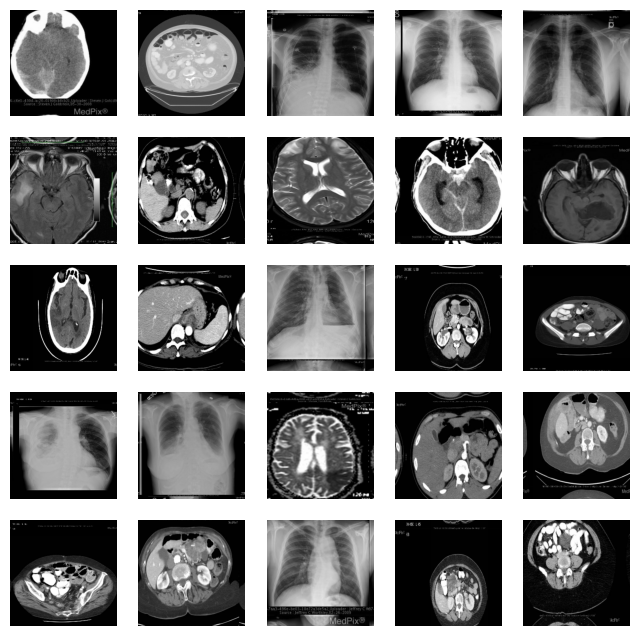

In [ ]:
fig, ax = plt.subplots(5,5, figsize = (8, 8))

for i in range(5):
    ax[i][0].imshow(images[i])
    ax[i][0].axis('off')
    ax[i][1].imshow(images[i+5])
    ax[i][1].axis('off')
    ax[i][2].imshow(images[i+10])
    ax[i][2].axis('off')
    ax[i][3].imshow(images[i+15])
    ax[i][3].axis('off')
    ax[i][4].imshow(images[i+20])
    ax[i][4].axis('off')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Embedding, Dense, Concatenate, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model

vocab_size = sequences.max() + 1

image_input = Input(shape=(256, 256, 3), name='image_input')
text_input = Input(shape=(10,), name='text_input')

image_branch = Conv2D(64, (3, 3), activation='relu', padding="same")(image_input)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.2)(image_branch)
image_branch = Conv2D(32, (3, 3), activation='relu', padding="same")(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.1)(image_branch)
image_branch = Conv2D(32, (3, 3), activation='relu', padding="same")(image_branch)
image_branch = MaxPooling2D((2, 2))(image_branch)
image_branch = Dropout(0.1)(image_branch)
image_branch = Flatten()(image_branch)

text_branch = Embedding(input_dim=vocab_size, output_dim=64)(text_input)
text_branch = Bidirectional(LSTM(64, return_sequences=False))(text_branch)
text_branch = Dropout(0.2)(text_branch)

combined = Concatenate()([image_branch, text_branch])
combined = Dropout(0.2)(combined)
combined = Dense(512, activation="relu")(combined)
combined = Dense(256, activation="relu")(combined)
combined = Dense(128, activation="relu")(combined)

output = Dense(1, activation='sigmoid')(combined)

model = keras.Model(inputs=[image_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

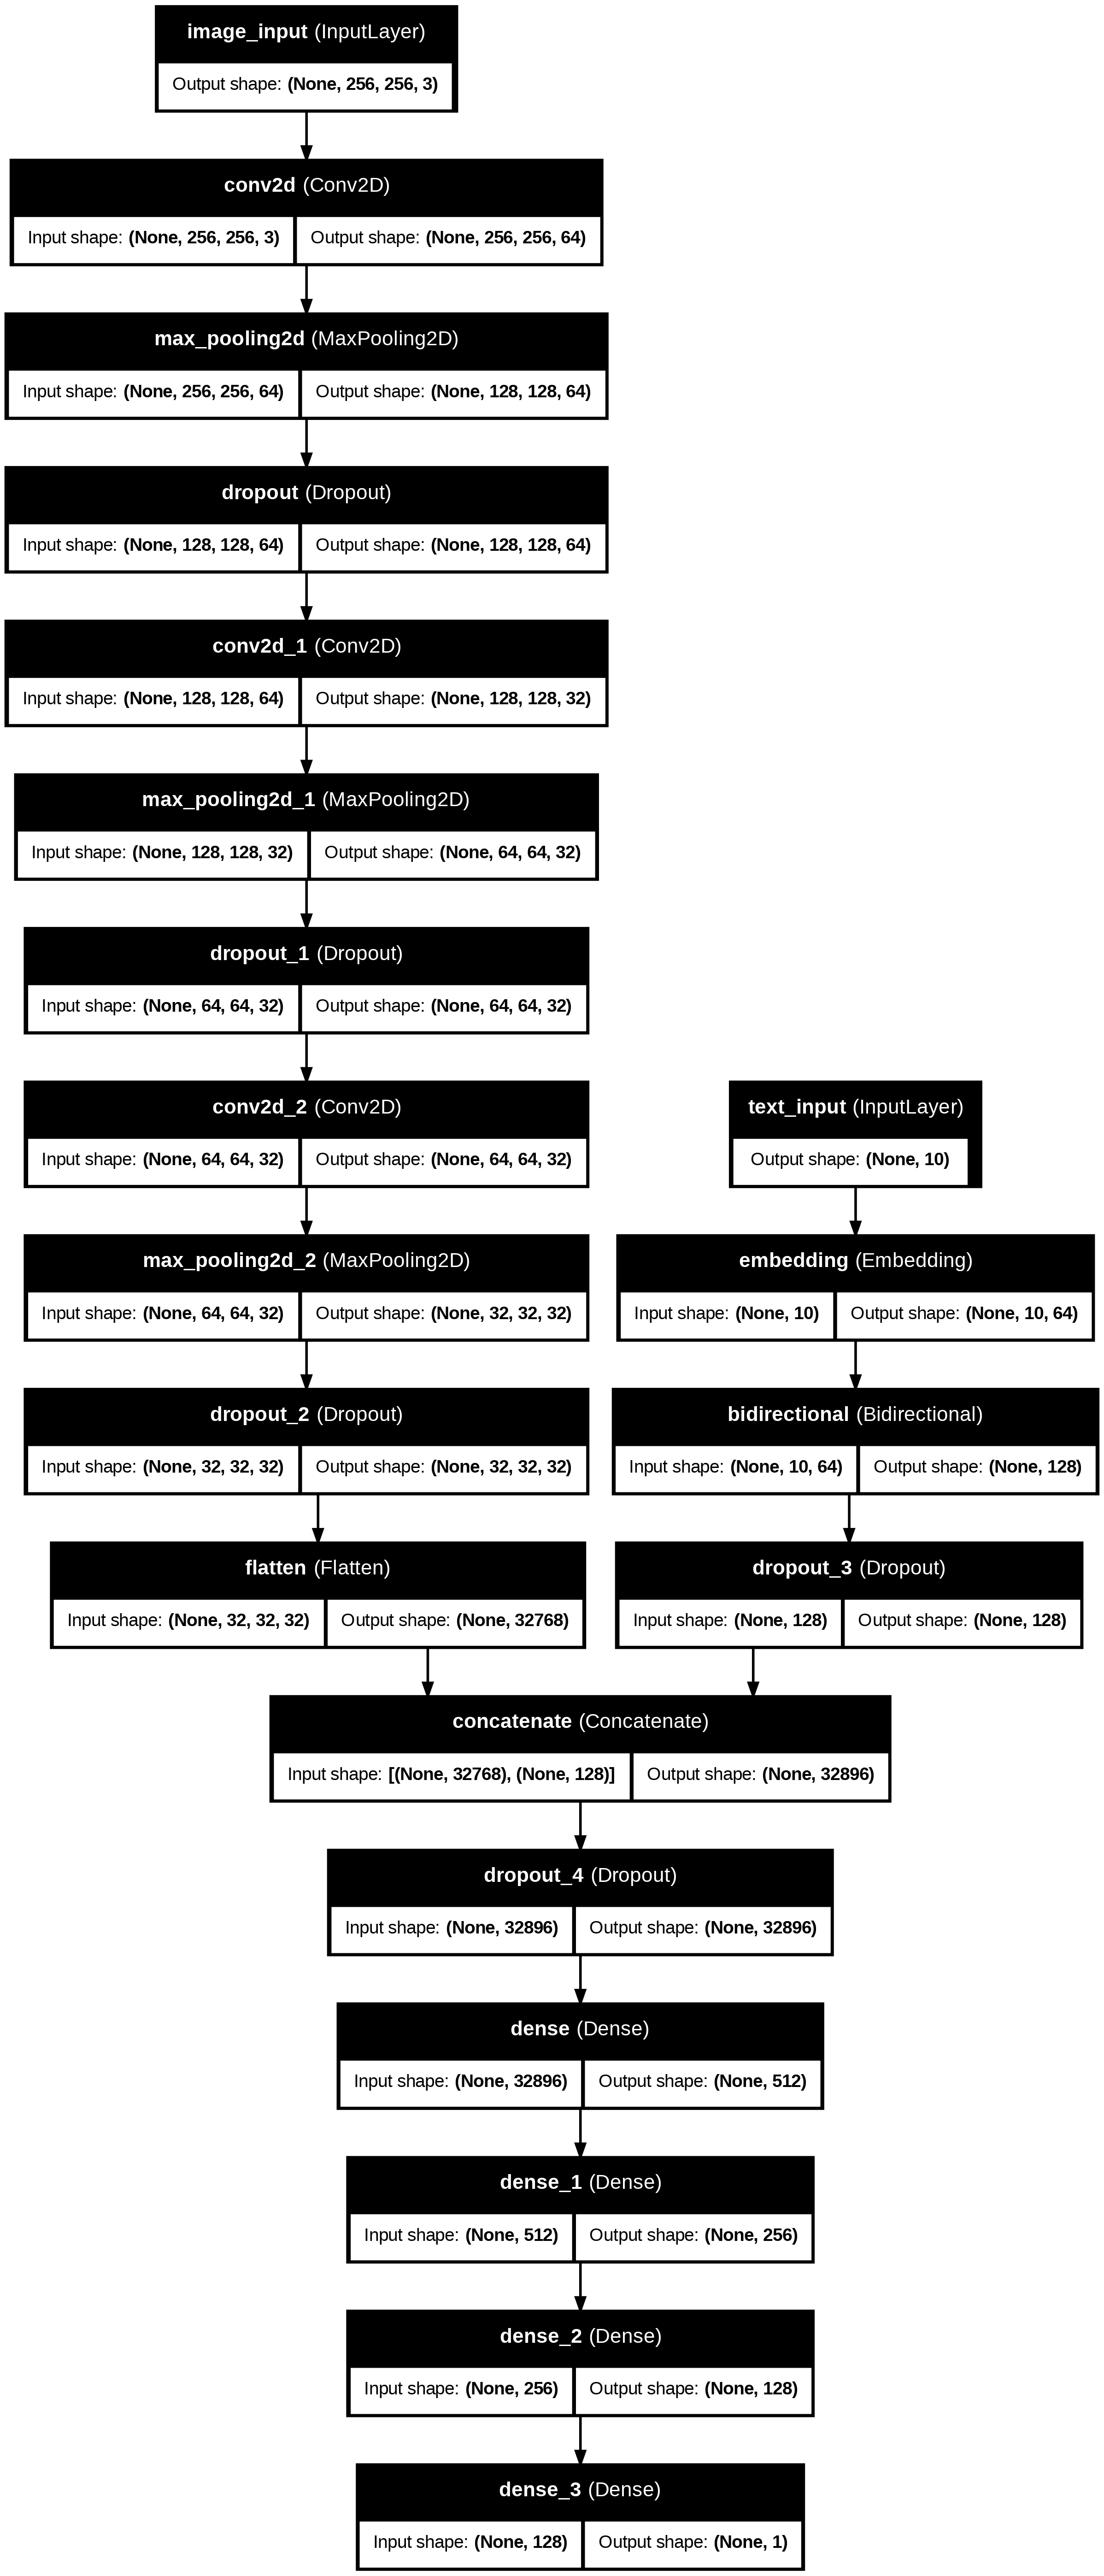

In [ ]:
plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/best.h5',
                                                  verbose=1, save_best_only = True,
                                                monitor='val_accuracy')

history = model.fit(
    train_data,
    epochs=15, batch_size=32,
    validation_data = val_data,
    callbacks = checkpointer
         )

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5104 - loss: 0.8242
Epoch 1: val_accuracy improved from -inf to 0.55230, saving model to /kaggle/working/best.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step - accuracy: 0.5104 - loss: 0.8227 - val_accuracy: 0.5523 - val_loss: 0.6882
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6238 - loss: 0.6364
Epoch 2: val_accuracy improved from 0.55230 to 0.67364, saving model to /kaggle/working/best.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - accuracy: 0.6249 - loss: 0.6353 - val_accuracy: 0.6736 - val_loss: 0.5591
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8474 - loss: 0.3778
Epoch 3: val_accuracy improved from 0.67364 to 0.72385, saving model to /kaggle/working/best.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - accuracy: 0.8474 - loss: 0.3775 - val_accuracy: 0.7238 - val_loss: 0.5907
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8951 - loss: 0.2522
Epoch 4: val_accuracy did not improve from 0.72385
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - accuracy: 0.8950 - loss: 0.2523 - val_accuracy: 0.7113 - val_loss: 0.6928
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9050 - loss: 0.2185
Epoch 5: val_accuracy improved from 0.72385 to 0.73640, saving model to /kaggle/working/best.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - accuracy: 0.9049 - loss: 0.2187 - val_accuracy: 0.7364 - val_loss: 0.7000
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9175 - loss: 0.1990
Epoch 6: val_accuracy did not improve from 0.73640
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - accuracy: 0.9174 - loss: 0.1992 - val_accuracy: 0.7071 - val_loss: 0.8279
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9283 - loss: 0.1734
Epoch 7: val_accuracy did not improve from 0.73640
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - accuracy: 0.9282 - loss: 0.1736 - val_accuracy: 0.7280 - val_loss: 0.9380
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9358 - loss: 0.1627
Epoch 8: val_accuracy did not improve from 0.73640
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - accuracy: 0.9357 - loss: 0.1628 - val_accuracy: 0.7322 - val_loss: 1.0072
Epoch 9/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9530 - loss: 0.1275
Epoch 9: val_accuracy did not i

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


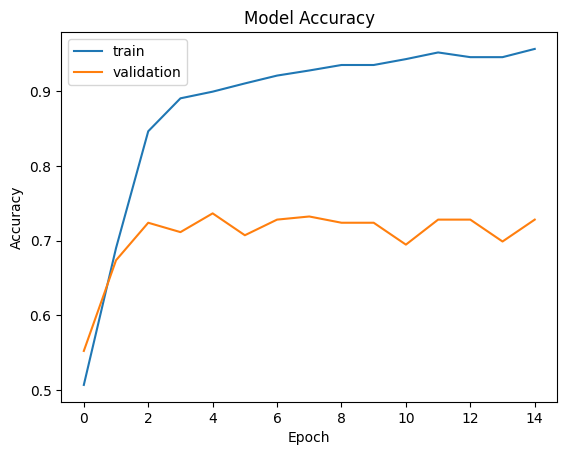

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
num_params = model.count_params()
model.save("/kaggle/working/temp_model.h5")
model_size_mb = os.path.getsize("/kaggle/working/temp_model.h5") / (1024 * 1024)

print("\n Model Info:")
print(f"Number of parameters: {num_params:,}")
print(f"Model size: {model_size_mb:.2f} MB")


 Model Info:
Number of parameters: 17,155,713
Model size: 196.43 MB


In [ ]:
test_batch = next(iter(val_data))
(test_images, test_texts), _ = test_batch
n_samples = len(test_images)

_ = model.predict((test_images[:1], test_texts[:1]))

start = time.time()
_ = model.predict((test_images, test_texts), verbose=0)
end = time.time()

avg_inference_time = (end - start) / n_samples * 1000  # in ms
print(f"\n Average inference time per sample: {avg_inference_time:.3f} ms")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step

 Average inference time per sample: 2.617 ms


In [ ]:
import tensorflow as tf
import tempfile
import os

concrete_func = tf.function(lambda x1, x2: model([x1, x2]))
concrete_func = concrete_func.get_concrete_function(
    tf.TensorSpec([1, 256, 256, 3], tf.float32),
    tf.TensorSpec([1, 10], tf.int32)
)

logdir = tempfile.mkdtemp()
tf.profiler.experimental.start(logdir)
_ = concrete_func(tf.random.normal([1,256,256,3]), tf.ones([1,10], dtype=tf.int32))
tf.profiler.experimental.stop()

from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

profile_opts = ProfileOptionBuilder.float_operation()  # Count float ops
profiler = model_analyzer.Profiler(graph=concrete_func.graph)
profile = profiler.profile_operations(options=profile_opts)

total_flops = profile.total_float_ops
flops_m = total_flops / 1e6
print(f" Estimated FLOPs: {flops_m:.2f} MFLOPs per forward pass")


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


 Estimated FLOPs: 949.68 MFLOPs per forward pass
